# Class Weight



## 0.환경준비

### 0.1 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 0.2 데이터 로딩

> 예제 데이터는 공정간 불량을 예측하는 데이터입니다.  
여기서는 class imbalance 에 대한 샘플링과 성능에만 초점을 맞추겠습니다.


In [2]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition2.csv"
data = pd.read_csv(path)

## 1.데이터 탐색

In [3]:
data.shape

(1150, 17)

In [4]:
data.head()

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1


## 2.데이터 준비

### 2.1 x, y 로 나누기

In [5]:
target = 'Attrition'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2.2 가변수화


In [6]:
dummy_vars = ['Education','Department','EducationField','Gender','JobRole','JobSatisfaction','MaritalStatus',
              'RelationshipSatisfaction','WorkLifeBalance'] # 가변수화 대상 변수 이름 리스트 만든다
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True) 

### 2.3 데이터 분할

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state=2022)

In [8]:
x_train.shape, y_train.shape

((805, 38), (805,))

## 3.모델링 + class weight 조정하기

In [9]:
# 필요한 라이브러리, 함수들을 불러옵시다.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import *

from sklearn.model_selection import GridSearchCV, StratifiedKFold

### 1) 기본 모델링

* 로지스틱 회귀 + 데이터 그대로 이용

In [10]:
model = LogisticRegression(solver = 'liblinear')
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[321   2]
 [ 20   2]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       323
           1       0.50      0.09      0.15        22

    accuracy                           0.94       345
   macro avg       0.72      0.54      0.56       345
weighted avg       0.91      0.94      0.92       345



### 2) Class Weight 조정

In [11]:
# loss 계산 수식 (그냥 넘어가도 됨)

def loss(y, y_hat):
    loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
    return loss

#### ① 로지스틱 회귀
> * class_weight = 'balanced'
* class_weight = 비율로 수동 조절

In [12]:
# class_weight = 'balanced'
 
model = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[238  85]
 [  4  18]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       323
           1       0.17      0.82      0.29        22

    accuracy                           0.74       345
   macro avg       0.58      0.78      0.57       345
weighted avg       0.93      0.74      0.81       345



In [13]:
result = []

for i in range(50):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .4)
    model = LogisticRegression(solver = 'liblinear', class_weight='balanced')
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    result.append(f1_score(y_val, pred, pos_label=1))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


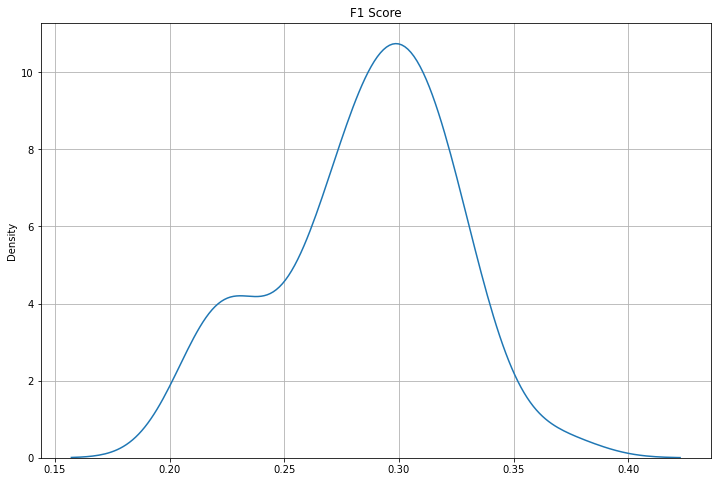

In [14]:
plt.figure(figsize=(12, 8))
sns.kdeplot(result)
plt.title('F1 Score')
plt.grid()
plt.show()

In [15]:
# class_weight = 비율로 수동 조절하도록 파라미터 설정
weights = np.linspace(0.0,.99,100)
params = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}
params

{'class_weight': [{0: 0.0, 1: 1.0},
  {0: 0.01, 1: 0.99},
  {0: 0.02, 1: 0.98},
  {0: 0.03, 1: 0.97},
  {0: 0.04, 1: 0.96},
  {0: 0.05, 1: 0.95},
  {0: 0.06, 1: 0.94},
  {0: 0.07, 1: 0.9299999999999999},
  {0: 0.08, 1: 0.92},
  {0: 0.09, 1: 0.91},
  {0: 0.1, 1: 0.9},
  {0: 0.11, 1: 0.89},
  {0: 0.12, 1: 0.88},
  {0: 0.13, 1: 0.87},
  {0: 0.14, 1: 0.86},
  {0: 0.15, 1: 0.85},
  {0: 0.16, 1: 0.84},
  {0: 0.17, 1: 0.83},
  {0: 0.18, 1: 0.8200000000000001},
  {0: 0.19, 1: 0.81},
  {0: 0.2, 1: 0.8},
  {0: 0.21, 1: 0.79},
  {0: 0.22, 1: 0.78},
  {0: 0.23, 1: 0.77},
  {0: 0.24, 1: 0.76},
  {0: 0.25, 1: 0.75},
  {0: 0.26, 1: 0.74},
  {0: 0.27, 1: 0.73},
  {0: 0.28, 1: 0.72},
  {0: 0.29, 1: 0.71},
  {0: 0.3, 1: 0.7},
  {0: 0.31, 1: 0.69},
  {0: 0.32, 1: 0.6799999999999999},
  {0: 0.33, 1: 0.6699999999999999},
  {0: 0.34, 1: 0.6599999999999999},
  {0: 0.35000000000000003, 1: 0.6499999999999999},
  {0: 0.36, 1: 0.64},
  {0: 0.37, 1: 0.63},
  {0: 0.38, 1: 0.62},
  {0: 0.39, 1: 0.61},
  {0: 0.4, 1:

In [16]:
# Grid Search : 그리드서치로 튜닝
# StratifiedKFold : 층화추출
model = GridSearchCV(LogisticRegression(solver = 'liblinear'), params
                    , cv= StratifiedKFold(5), scoring='f1')
model.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(solver='liblinear'),
             param_grid={'class_weight': [{0: 0.0, 1: 1.0}, {0: 0.01, 1: 0.99},
                                          {0: 0.02, 1: 0.98},
                                          {0: 0.03, 1: 0.97},
                                          {0: 0.04, 1: 0.96},
                                          {0: 0.05, 1: 0.95},
                                          {0: 0.06, 1: 0.94},
                                          {0: 0.07, 1: 0.9299999999999999},
                                          {0: 0.08, 1: 0.92},
                                          {0: 0.09, 1: 0.91}, {0: 0.1, 1: 0.9},
                                          {0: 0.11, 1: 0.89},
                                          {0: 0.12, 1: 0.88},
                                          {0: 0.13, 1: 0.87},
                                          {0: 0.14, 1: 0.86},
  

In [17]:
y_train.value_counts()/y_train.shape[0]

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

In [18]:
model.cv_results_

{'mean_fit_time': array([0.00698781, 0.00799799, 0.00917573, 0.00842862, 0.00937924,
        0.00859017, 0.00860229, 0.00838432, 0.00914388, 0.00909185,
        0.00896029, 0.0083478 , 0.0088109 , 0.00873494, 0.00940766,
        0.01055546, 0.01199164, 0.01189728, 0.00876231, 0.00918255,
        0.00841131, 0.00918565, 0.00865283, 0.00941133, 0.00831485,
        0.00877604, 0.00786309, 0.00878043, 0.00822053, 0.00956807,
        0.00864329, 0.00835881, 0.0108036 , 0.00978208, 0.00864229,
        0.00887909, 0.00948243, 0.00918088, 0.00977287, 0.00798202,
        0.00938449, 0.00878386, 0.00979004, 0.00943904, 0.00952935,
        0.00863643, 0.0107079 , 0.01038222, 0.00806756, 0.00909405,
        0.0088058 , 0.00992842, 0.00842137, 0.00896311, 0.00837603,
        0.00884972, 0.00966902, 0.01041093, 0.00863647, 0.00820985,
        0.00873313, 0.00816355, 0.00839348, 0.00864305, 0.00774579,
        0.00817795, 0.00819736, 0.00760245, 0.00899806, 0.01003118,
        0.00870037, 0.00799665,

{'class_weight': {0: 0.17, 1: 0.83}}


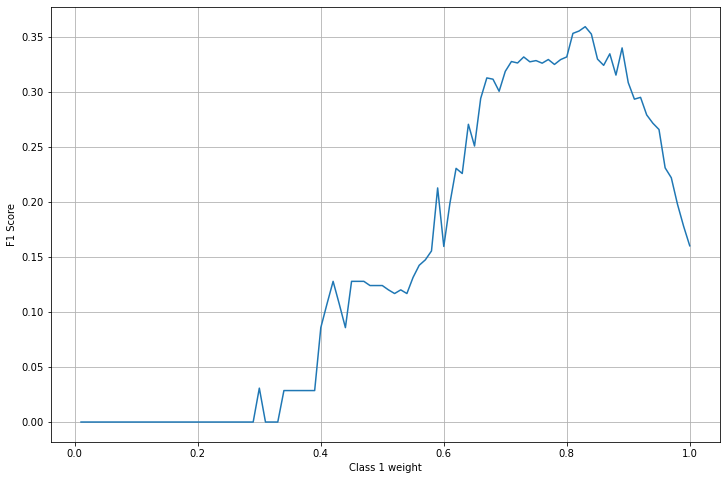

In [19]:
weight_1 = 1.0 - weights
f1 = model.cv_results_['mean_test_score']

print(model.best_params_)
plt.figure(figsize=(12, 8))
plt.plot(weight_1, f1)
plt.ylabel('F1 Score')
plt.xlabel('Class 1 weight')
plt.grid()
plt.show()

#### ③ 추가 실험

* 이해하기, 사용하기 쉬운 데이터로 몇가지 실험을 해 봅시다.

In [ ]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/titanic.1.csv'
titanic = pd.read_csv(path, usecols=['Survived', 'Age', 'Fare'])
target = 'Survived'
x1 = titanic.drop(target, axis = 1)
y1 = titanic.loc[:, target]

In [ ]:
# 클래스별 비율
c_rate = np.bincount(y1) / y1.shape[0]
c_rate

In [ ]:
# 실험1 : 아무것도 없으면 1:1 ?
m1 = LogisticRegression(solver = 'liblinear')
wt = 0.5
m2 = LogisticRegression(solver = 'liblinear', class_weight= {0:wt, 1:1-wt})

# 실험2 : balanced는 클래스비율 역으로 지정?
m3 = LogisticRegression(solver = 'liblinear', class_weight='balanced')
wt = c_rate[1]
m4 = LogisticRegression(solver = 'liblinear', class_weight= {0:wt, 1:1-wt})

m1.fit(x1, y1)
m2.fit(x1, y1)
m3.fit(x1, y1)
m4.fit(x1, y1)

In [ ]:
print(list(x1))
print('-'*50)
print(m1.coef_, m1.intercept_)
print(m2.coef_, m2.intercept_)
print('-'*50)
print(m3.coef_, m3.intercept_)
print(m4.coef_, m4.intercept_)

#### ② Decision Tree
> * class_weight = 'balanced'
* class_weight = 비율로 수동 조절

In [ ]:
# 실험1 
m1 = DecisionTreeClassifier(max_depth = 2)

wt = 0.5
m2 = DecisionTreeClassifier(max_depth = 2, class_weight= {0:wt, 1:1-wt})

m1.fit(x1, y1)
m2.fit(x1, y1)

plt.figure(figsize = (10,6))
plot_tree(m1, feature_names = list(x1), class_names = ['Died', 'Survived'], rounded = True, filled = True)
plt.show()
plt.figure(figsize = (10,6))
plot_tree(m2, feature_names = list(x1), class_names = ['Died', 'Survived'], rounded = True, filled = True)
plt.show()

In [ ]:
c_rate = np.bincount(y1) / y1.shape[0]
c_rate

In [ ]:
# 실험2 : balanced
m3 = DecisionTreeClassifier(max_depth = 2, class_weight='balanced')

wt = c_rate[1]
m4 = DecisionTreeClassifier(max_depth = 2, class_weight= {0:wt, 1:1-wt})

m3.fit(x1, y1)
m4.fit(x1, y1)

plt.figure(figsize = (10,6))
plot_tree(m3, feature_names = list(x1), class_names = ['Died', 'Survived'], rounded = True, filled = True)
plt.show()
plt.figure(figsize = (10,6))
plot_tree(m4, feature_names = list(x1), class_names = ['Died', 'Survived'], rounded = True, filled = True)
plt.show()

## 4.실습 : Semiconductor manufacturing process dataset


![](https://assets.pandaily.com/uploads/2021/10/semiconductor.png)

* 반도체 제조 공정은 시점별로 수많은 센서로부터 정보를 수집하여 공정을 감시합니다. 
* 센서정보와 함께 공정간 발생된 불량품에 대한 정보를 저장하였습니다.
* 불량을 예측해 봅시다.

### 4.1 데이터 준비

* 데이터 로딩

In [20]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/secom_9.csv"
data = pd.read_csv(path)

data['label'] = 0
data.loc[data['defeat']== 'defeat', 'label']= 1
data.drop(['datetime','defeat'], axis = 1, inplace=True)
data.head()

,v021,v087,v088,v089,v114,v115,v116,v117,v118,v120,...,v528,v571,v572,v573,v574,v575,v576,v577,v578,label
0,1.4026,2.3895,0.9690,1747.6049,0.9460,0.0,748.6115,0.9908,58.4306,0.9804,...,6.6926,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0
1,1.3825,2.3754,0.9894,1931.6464,0.9425,0.0,731.2517,0.9902,58.6680,0.9731,...,8.8370,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0
2,1.4123,2.4532,0.9880,1685.8514,0.9231,0.0,718.5777,0.9899,58.4808,0.9772,...,6.4568,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,1
3,1.4011,2.4004,0.9904,1752.0968,0.9564,0.0,709.0867,0.9906,58.6635,0.9761,...,6.4865,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0
4,1.3888,2.4530,0.9902,1828.3846,0.9424,0.0,796.5950,0.9908,58.3858,0.9628,...,6.3745,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,0


변수 정보 
* label : 1 - 불량, 0 - 정상
* v### : 센서값들


In [21]:
target = 'label'

In [22]:
data[target].value_counts() / data.shape[0]

0    0.933631
1    0.066369
Name: label, dtype: float64

* x, y로 나누기 

In [23]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 가변수화 Dummy Variable

* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2022)

In [26]:
print(x_train.shape, x_val.shape)

(1253, 52) (314, 52)


### 2)기본모델링
> * 데이터셋을 그대로 모델링을 수행하시오.
* 알고리즘 : 로지스틱회귀, decision tree 중 하나 사용.
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.


In [27]:
model = LogisticRegression(solver = 'liblinear')
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[295   1]
 [ 18   0]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       296
           1       0.00      0.00      0.00        18

    accuracy                           0.94       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.89      0.94      0.91       314



### 2)모델링 + class weight 조정
> * class_weight 값을 지정해서 모델링 해 봅시다.
* 알고리즘 : 비교를 위해서 기본모델링에 사용한 알고리즘 사용
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.
* resampling 후 수행한 모델과 성능에 대해 비교해 봅시다.

In [28]:
# class_weight = 'balanced'
model_w = LogisticRegression(solver='liblinear', class_weight='balanced') 
model_w.fit(x_train, y_train)

pred_w = model_w.predict(x_val)

print(confusion_matrix(y_val, pred_w))
print('-'*52)
print(classification_report(y_val, pred_w))

[[180 116]
 [  8  10]]
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.61      0.74       296
           1       0.08      0.56      0.14        18

    accuracy                           0.61       314
   macro avg       0.52      0.58      0.44       314
weighted avg       0.91      0.61      0.71       314



* 로지스틱 회귀로 반복 실험

* GridSearch로 class weight 조절